<a href="https://colab.research.google.com/github/yeseul106/GAN_Project/blob/main/GAN_pix2pix_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [30]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import TensorFlow and other libraries

In [54]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from numpy import load
from matplotlib import pyplot as plt
from IPython import display

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load the dataset

Download the CMP Facade Database data (30MB). Additional datasets are available in the same format [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). In Colab you can select other datasets from the drop-down menu. Note that some of the other datasets are significantly larger (`edges2handbags` is 8GB). 

loaded: (38, 256, 256, 3) (38, 256, 256, 3)


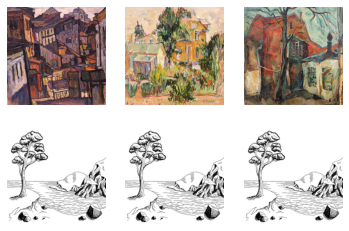

In [5]:
data = load("/content/drive/MyDrive/Colab/GANProject/dataset/Impressionism/output/imporessionisom.npz")
src_image, targ_image = data["arr_0"], data["arr_1"]
print("loaded:", src_image.shape, targ_image.shape)
n=3
for i in range(n):
  pyplot.subplot(2,n,1+i)
  pyplot.axis("off")
  pyplot.imshow(src_image[i].astype("uint8"))

for i in range(n):
  pyplot.subplot(2,n,1+n+i)
  pyplot.axis("off")
  pyplot.imshow(targ_image[i].astype("uint8"))

In [7]:
PATH = "/content/drive/MyDrive/Colab/GANProject/dataset/Color_Field_Painting"

## Resize and Normalize Image

In [8]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [36]:
def resize(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  
  print('Nomalizing the images to [-1, 1]')

  return input_image

In [32]:
def load(image_file):
  real_image = tf.io.read_file(image_file)
  real_image = tf.io.decode_jpeg(real_image)

  # Convert both images to float32 tensors
  real_image = tf.cast(real_image, tf.float32)

  return real_image

In [33]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  resize(input_image)  
  print('Nomalizing the images to [-1, 1]')

  return input_image

In [34]:
def load_image_test(image_file):
  input_image = load(image_file)
  input_image = resize(input_image,IMG_HEIGHT, IMG_WIDTH)
  input_image = normalize(input_image)

  return input_image

In [61]:
def load_image_train(image_file):
  input_image = load(image_file, allow_pickle=True)
  input_image = resize(input_image,IMG_HEIGHT, IMG_WIDTH)
  input_image = normalize(input_image)

  return input_image

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [19]:
OUTPUT_CHANNELS = 3

In [37]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [38]:
inp = load('/content/drive/MyDrive/Colab/GANProject/dataset/Color_Field_Painting/ad-reinhardt_blue-painting-1953.jpg')

In [39]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 723, 541, 3)


Define the upsampler (decoder):

In [41]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [42]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 1446, 1082, 3)


Define the generator with the downsampler and the upsampler:

In [43]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

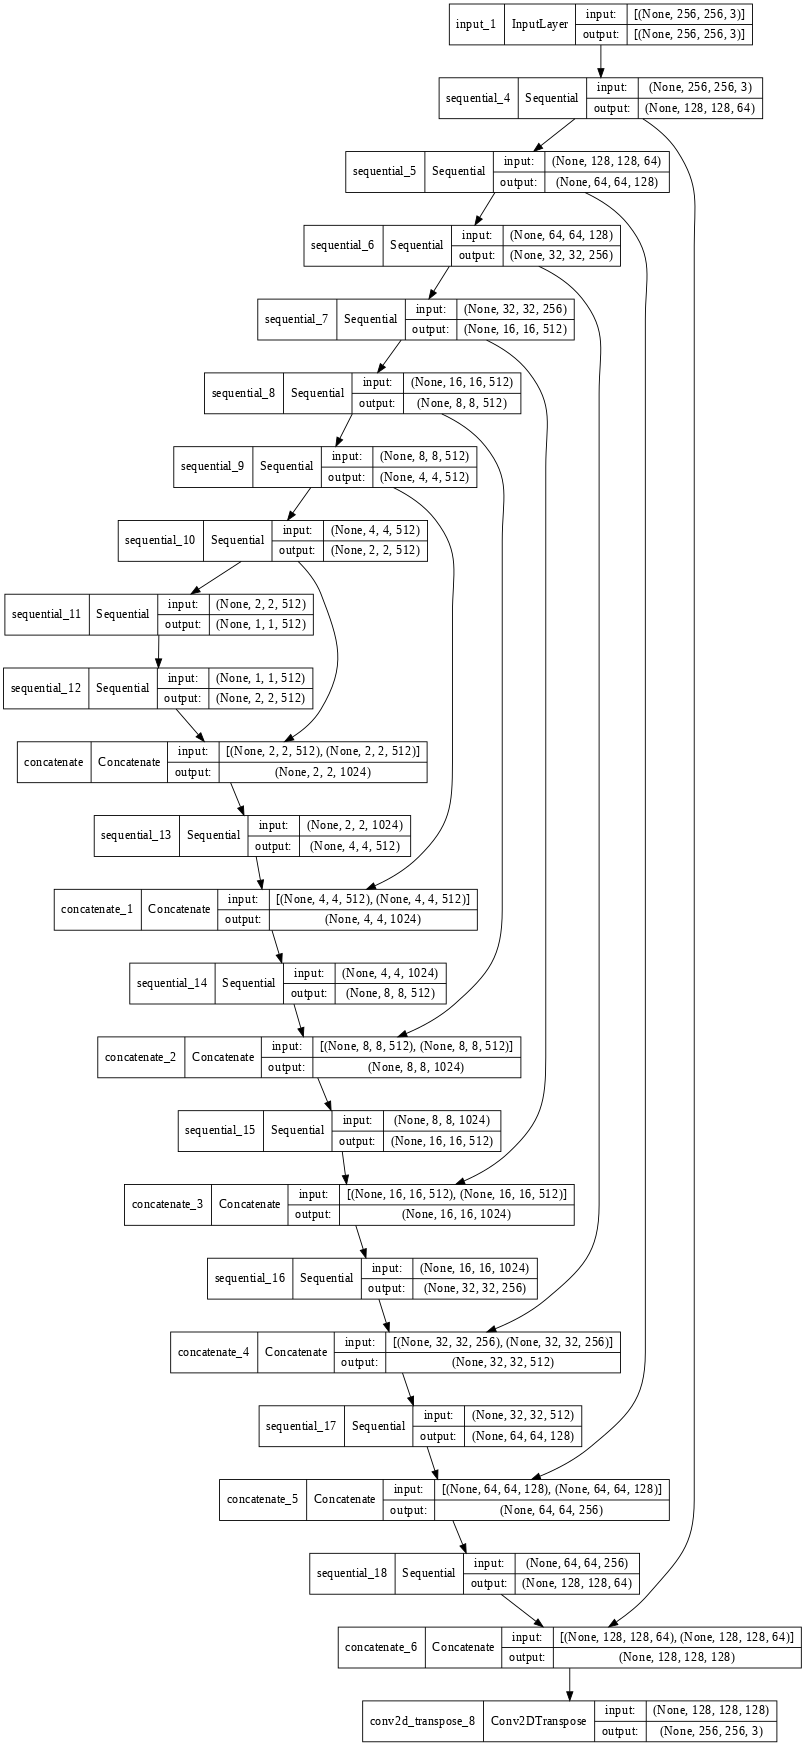

In [44]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [46]:
LAMBDA = 100

In [47]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [48]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [49]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

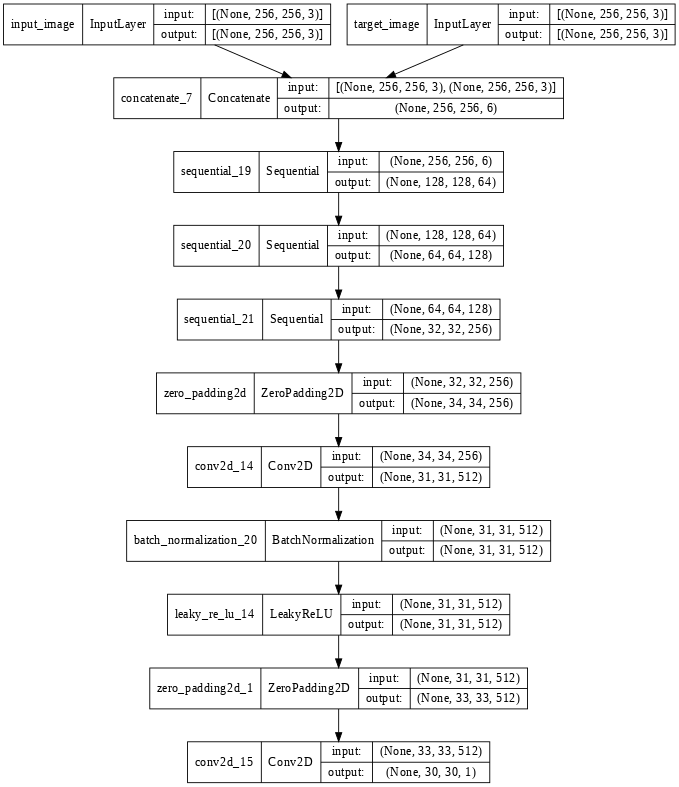

In [50]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [51]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [52]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since
you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [56]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [72]:
test_dataset = load("/content/drive/MyDrive/Colab/GANProject/dataset/Impressionism/target/lan.png")

ValueError: ignored

In [ ]:
# Cannot load file containing pickled data when allow_pickle=False


Test the function:

In [74]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

ValueError: ignored

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [ ]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Finally, run the training loop:

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
!ls {checkpoint_dir}

In [ ]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset:
  generate_images(generator, inp, tar)